In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [3]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
# Define data loading step

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#dataset = MNIST('./data', transform=img_transform, download=True)
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
kwargs = {'num_workers': 8, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=img_transform),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=img_transform),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 16  # for standard AE (under-complete hidden layer)
#d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [8]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epoch [1/20], loss:0.2472
epoch [2/20], loss:0.1976
epoch [3/20], loss:0.1561
epoch [4/20], loss:0.1481
epoch [5/20], loss:0.1281
epoch [6/20], loss:0.1257
epoch [7/20], loss:0.1214
epoch [8/20], loss:0.1106
epoch [9/20], loss:0.1079
epoch [10/20], loss:0.1050
epoch [11/20], loss:0.1060
epoch [12/20], loss:0.1065
epoch [13/20], loss:0.0963
epoch [14/20], loss:0.1063
epoch [15/20], loss:0.0924
epoch [16/20], loss:0.0879
epoch [17/20], loss:0.0936
epoch [18/20], loss:0.0903
epoch [19/20], loss:0.0954
epoch [20/20], loss:0.0931


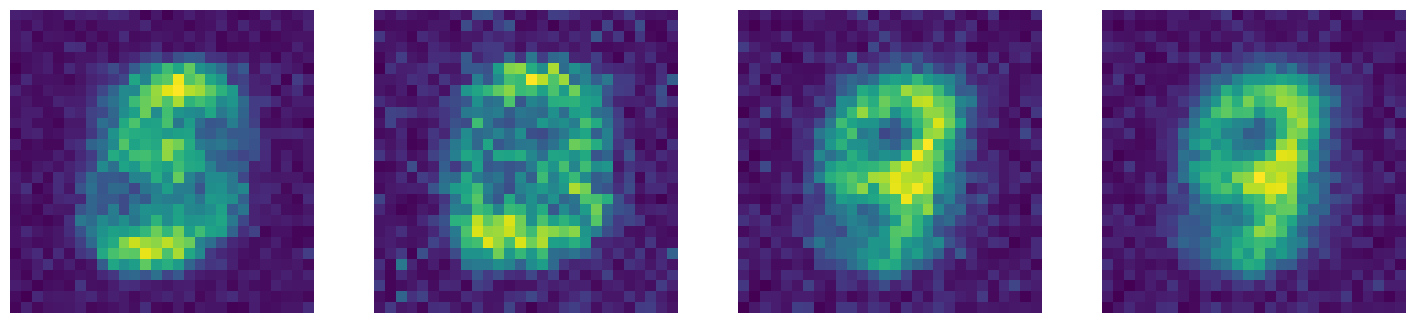

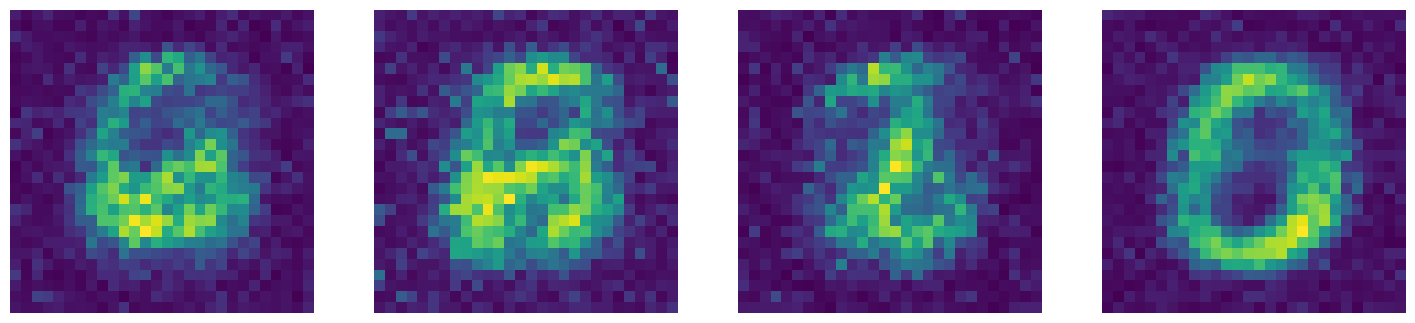

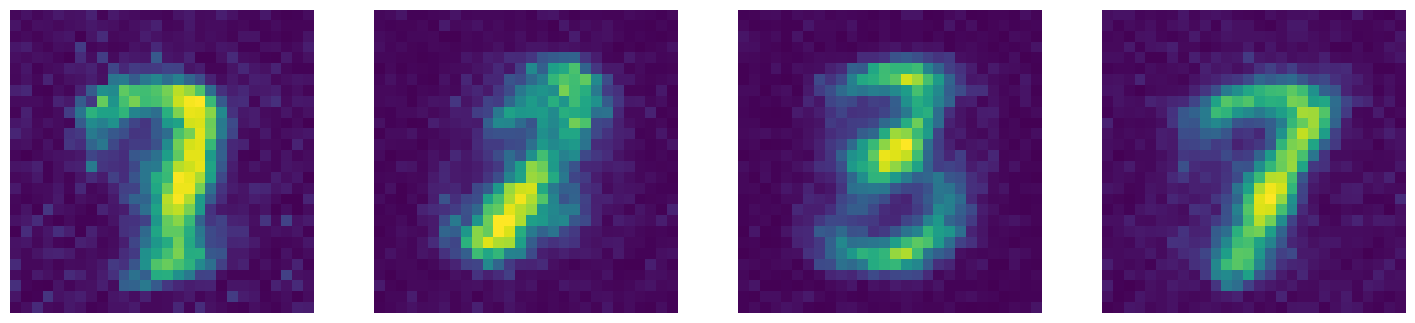

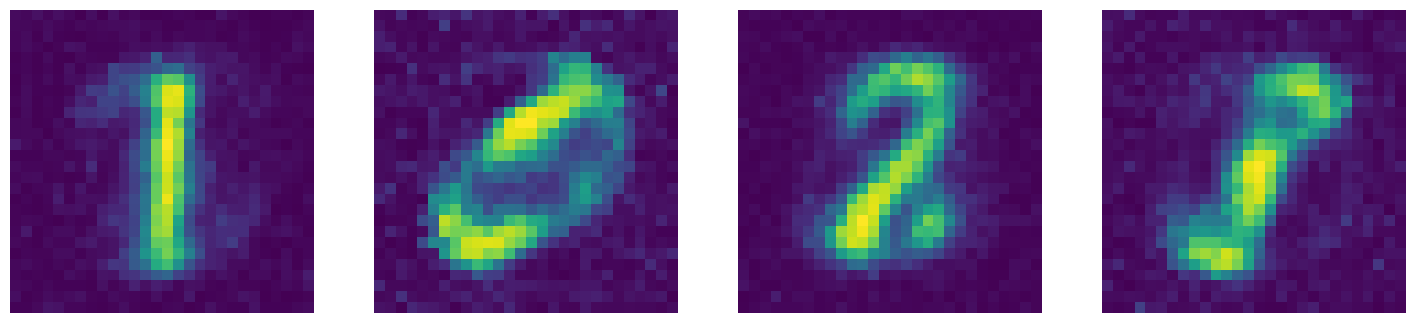

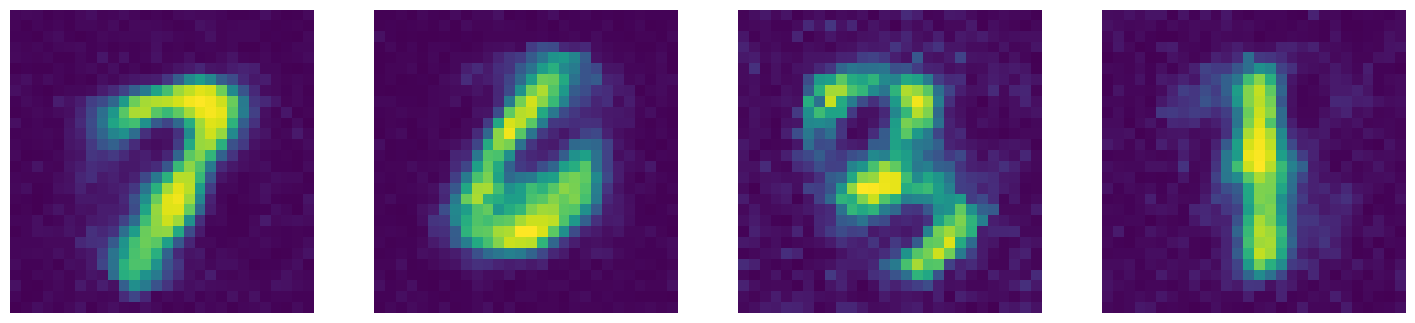

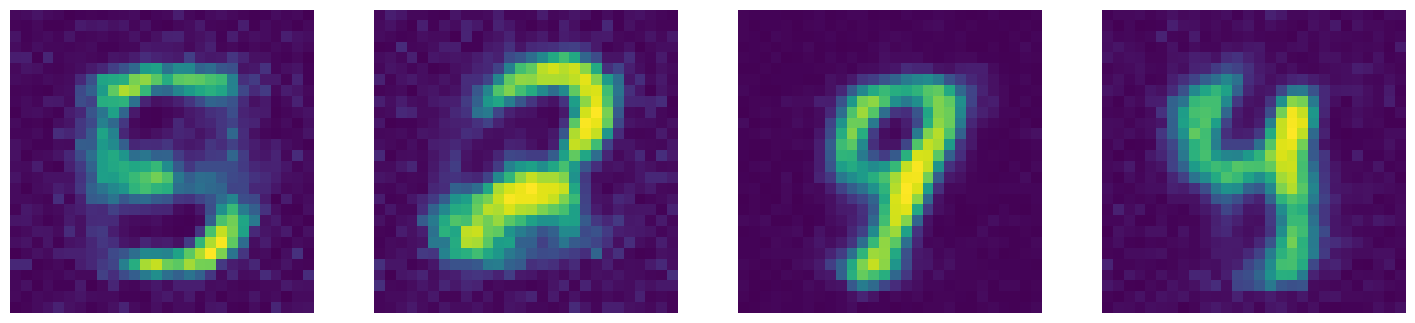

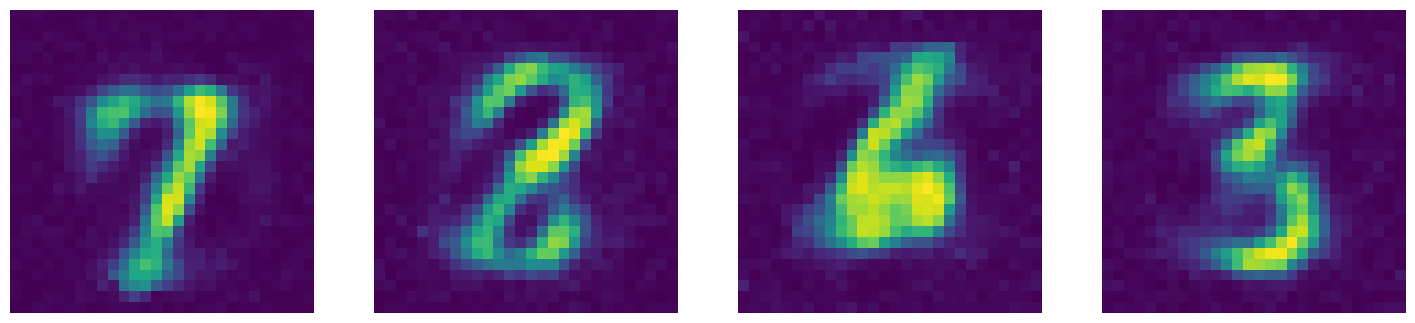

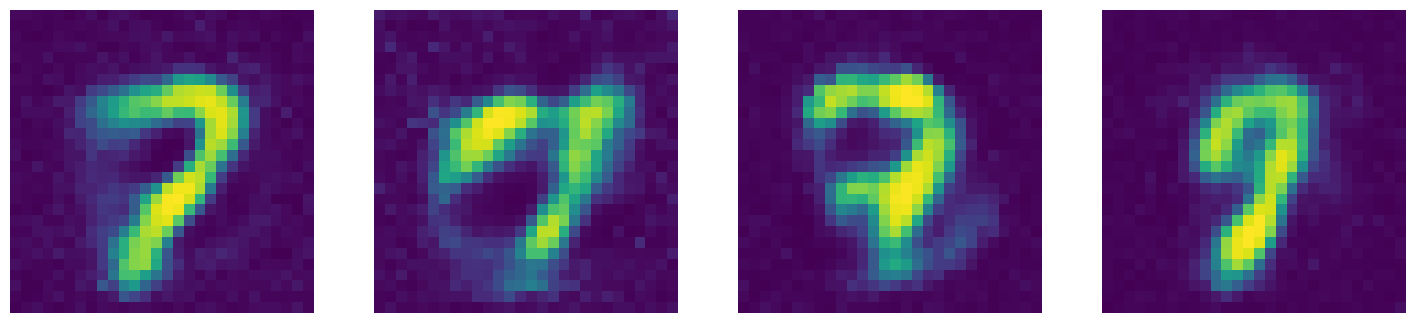

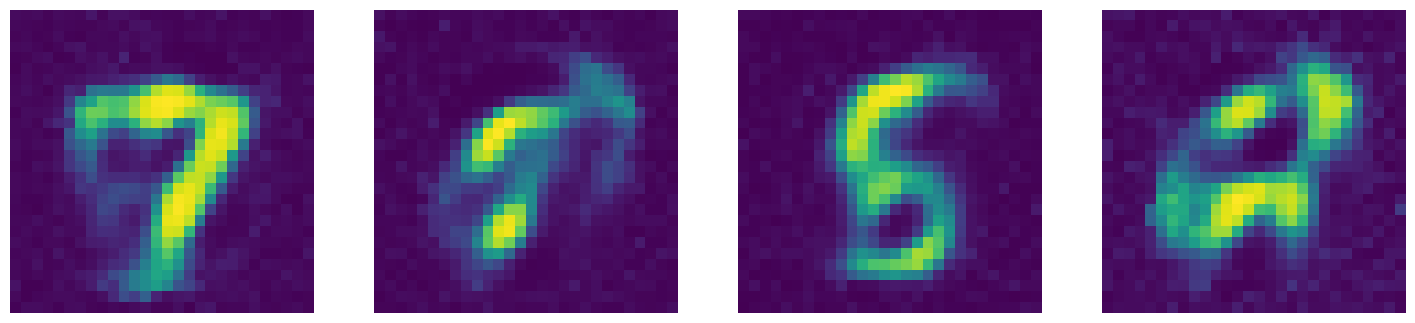

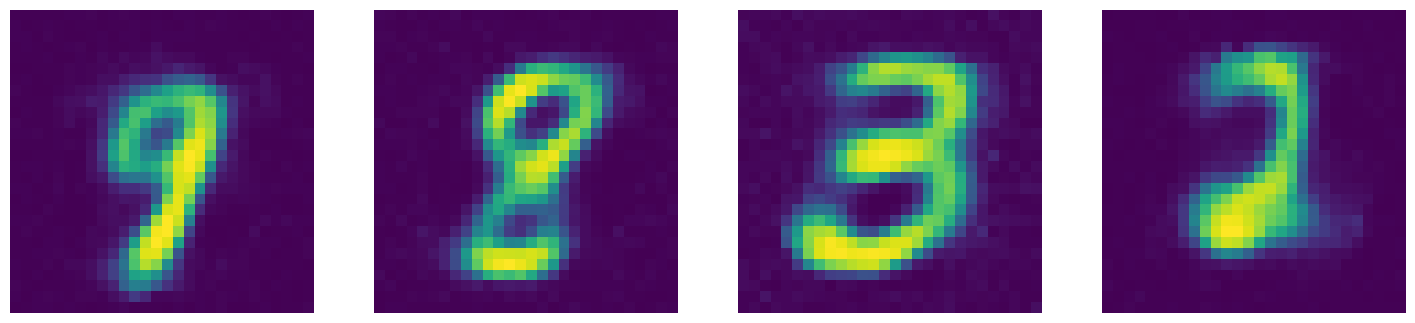

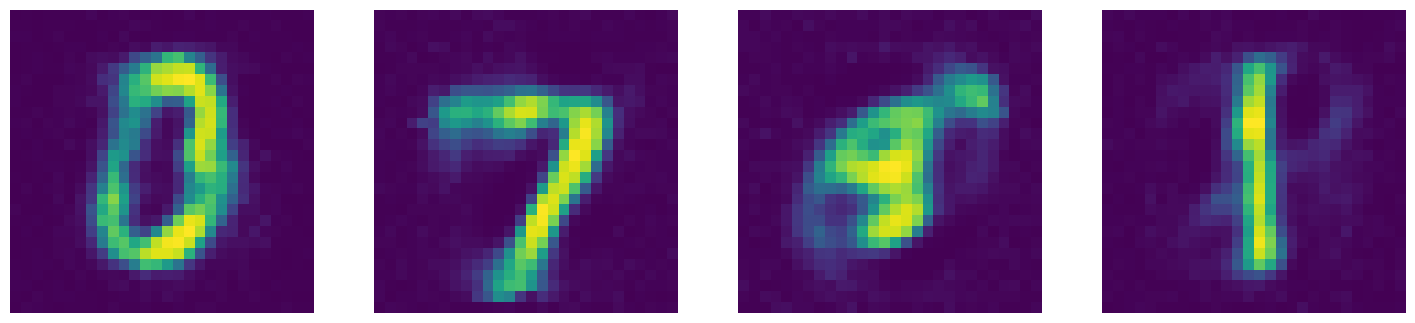

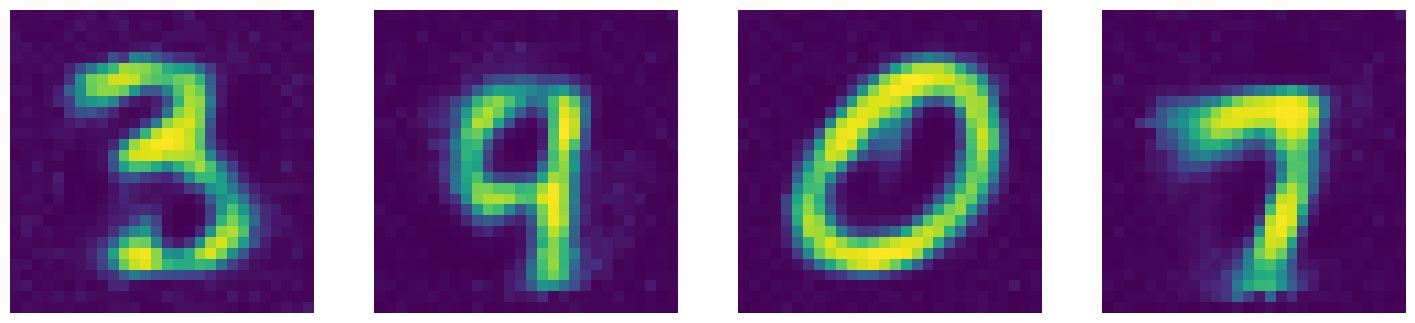

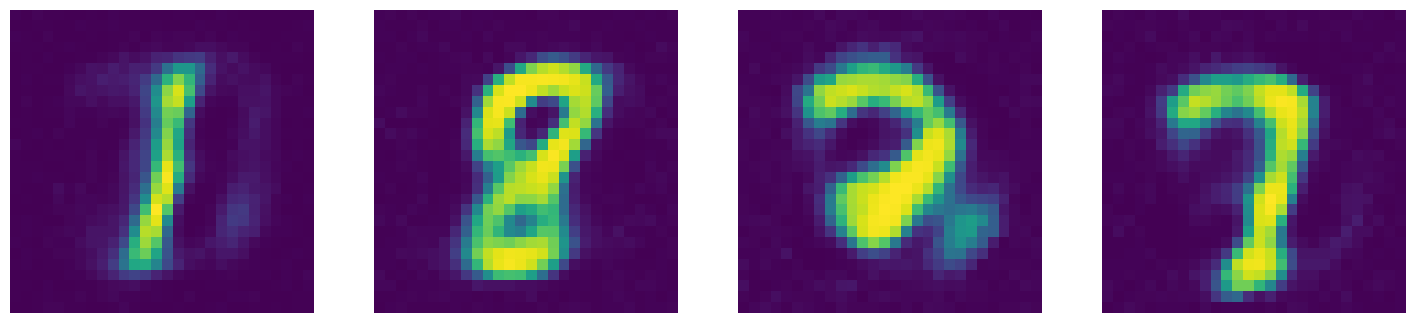

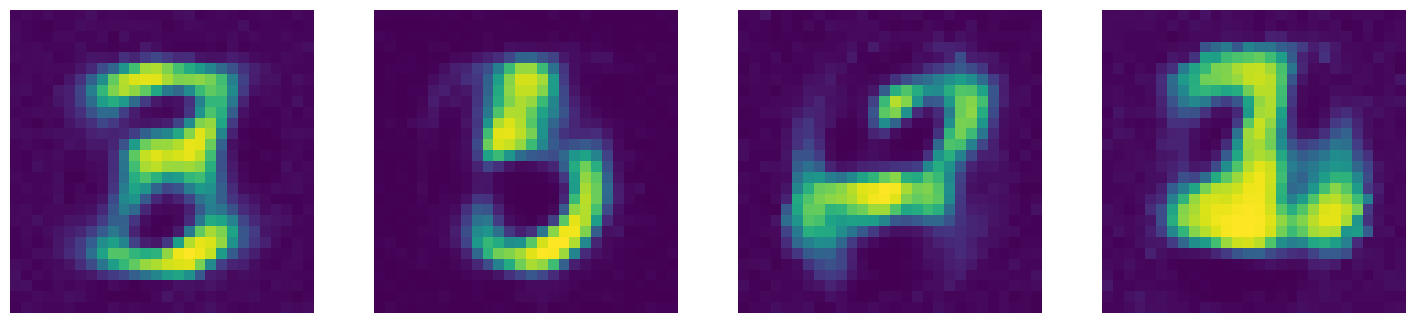

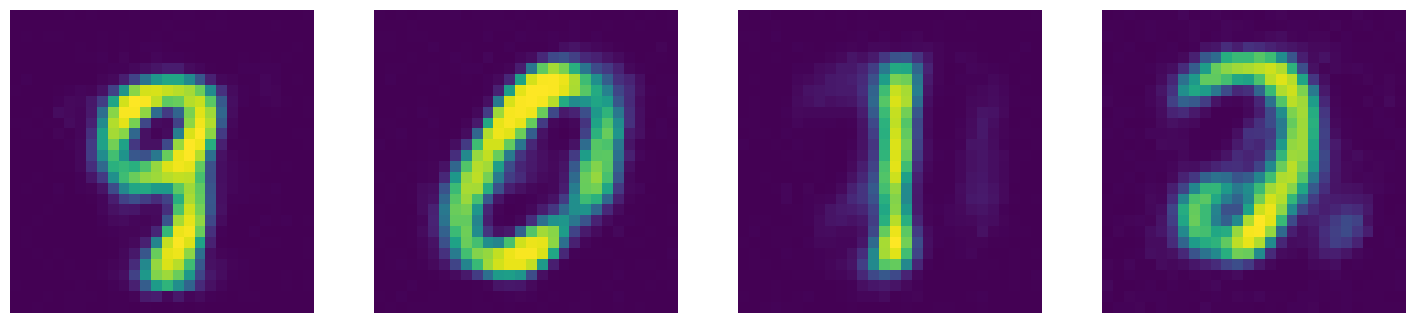

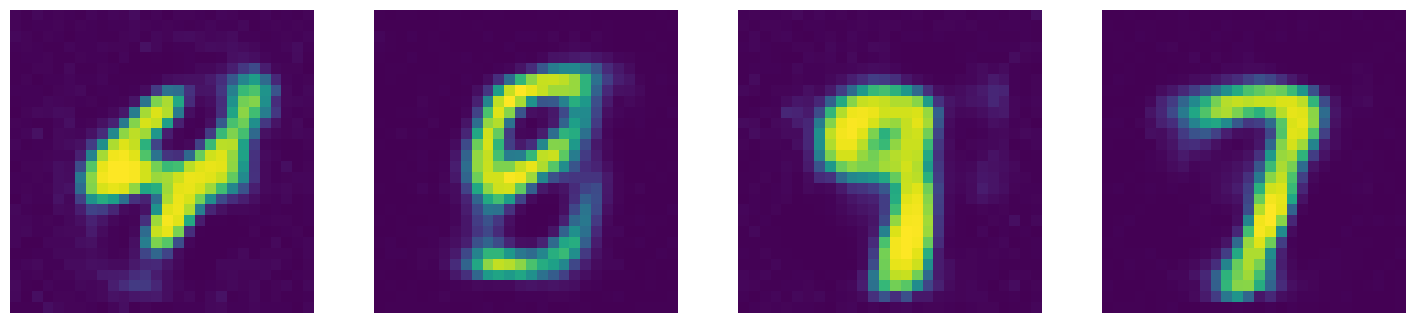

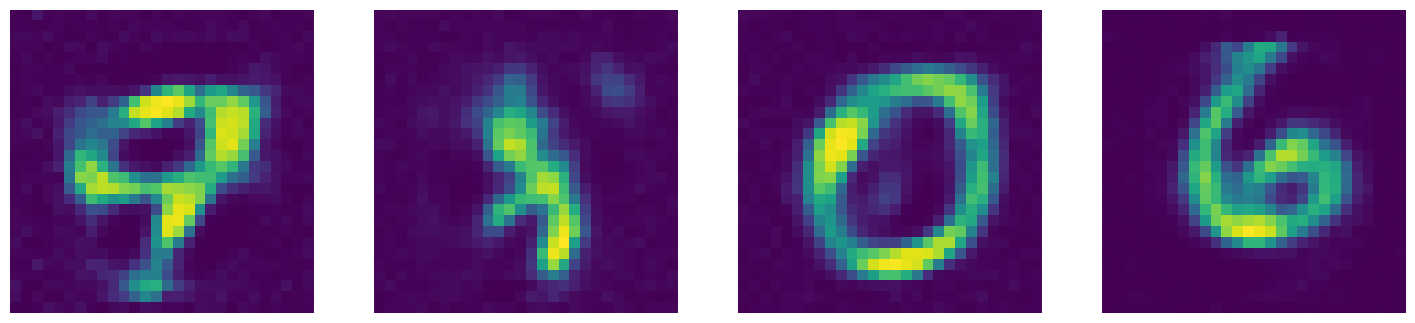

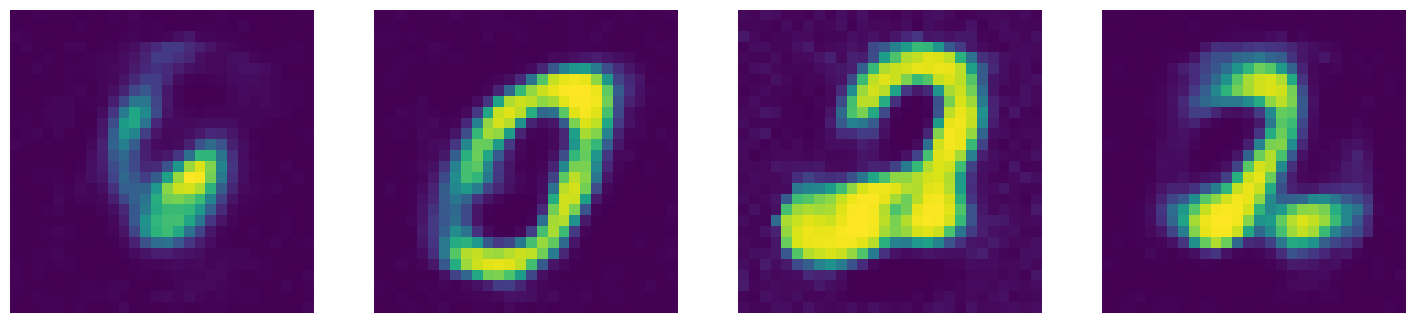

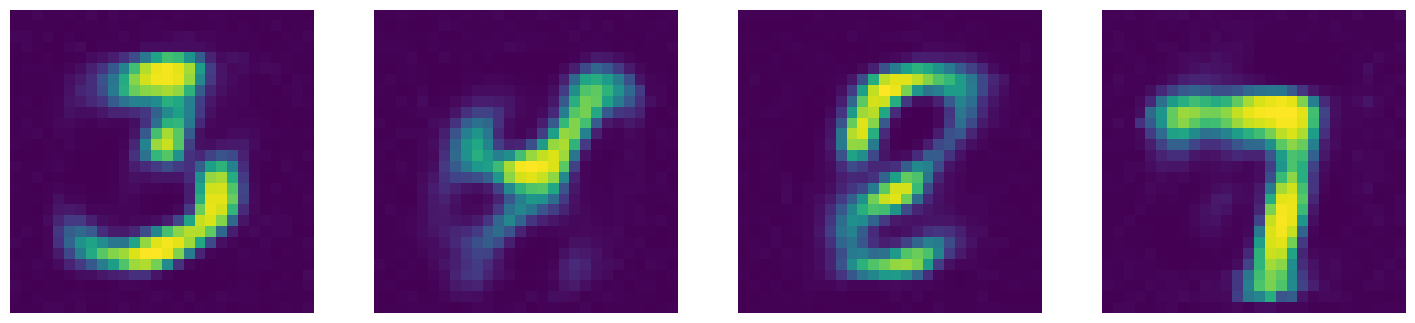

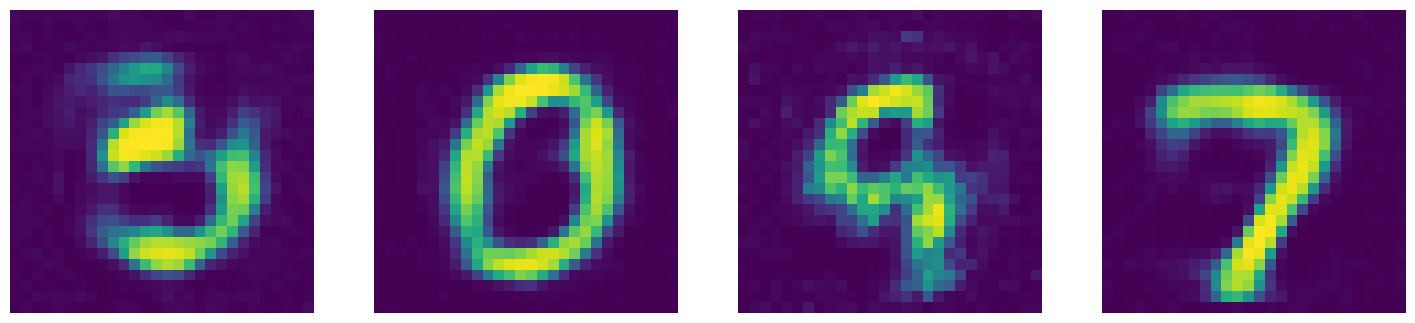

In [9]:
# Train standard or denoising autoencoder (AE)
latent_vecs, y_s = [], []

num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        
        output = model(img)  
        loss = criterion(output, img.data)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  
    
    latent_vec, label = list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            x = x.view(x.size(0), -1)
            
            latent_vec.append(model.encoder(x).cpu().detach().numpy())
            label.append(y.cpu().detach().numpy())
            
    # ===================log========================
    
    latent_vecs.append(np.concatenate(latent_vec, axis = 0))
    y_s.append(np.concatenate(label, axis = 0))
    

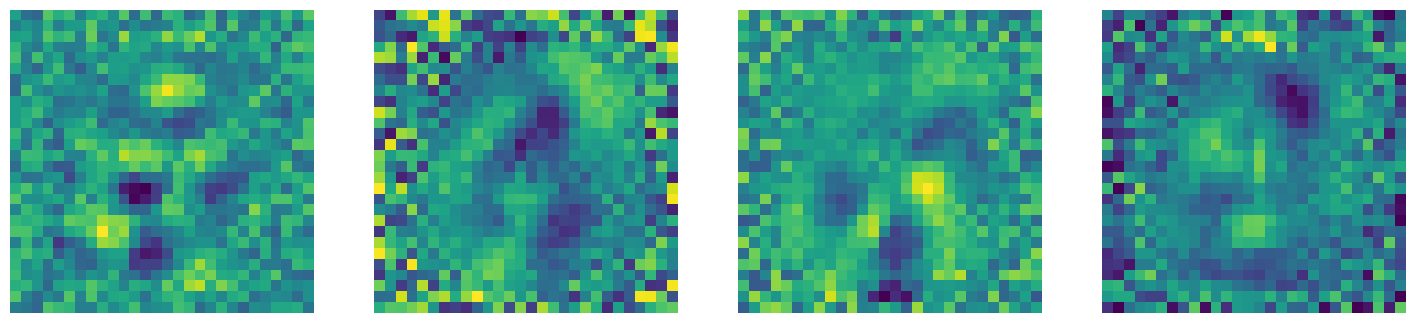

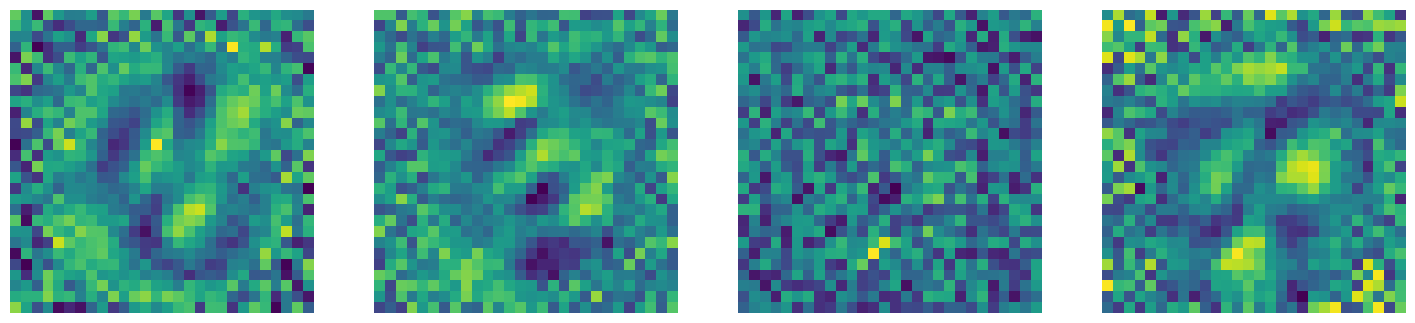

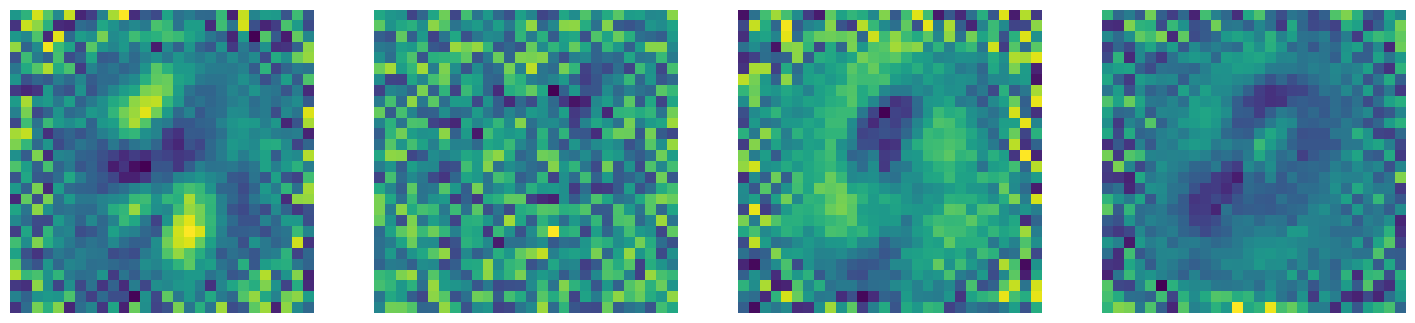

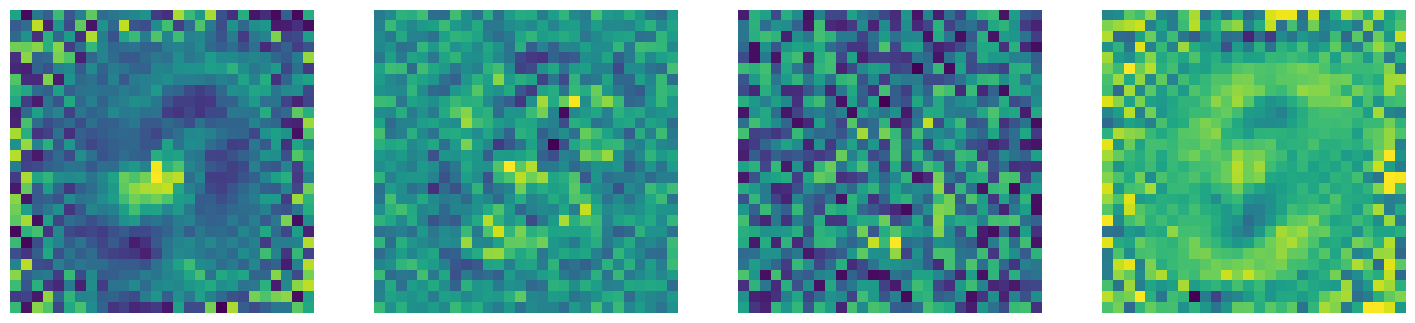

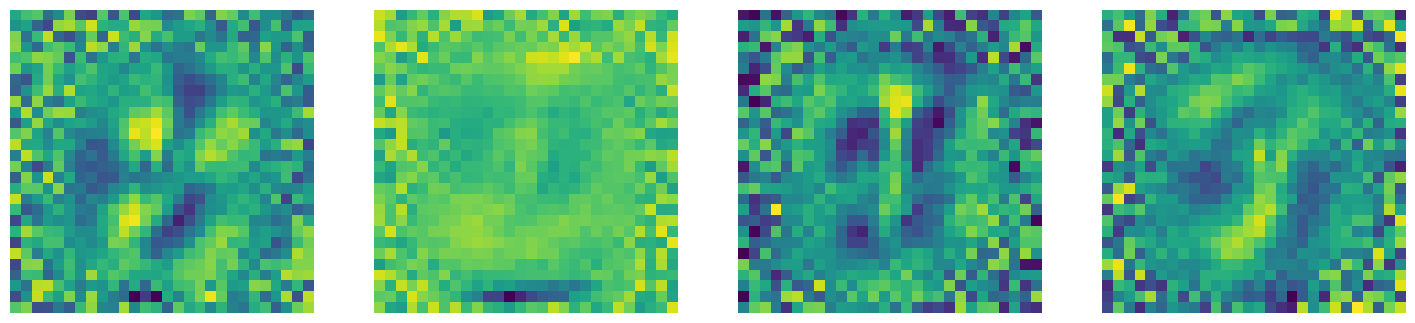

In [10]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

In [11]:
import numpy as np
from sklearn.manifold import TSNE

def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [12]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10, 15)
for epoch in epochs:
    X.append(latent_vecs[epoch][:N])
    Y.append(y_s[epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))

In [13]:
set_default(figsize=(25, 6))

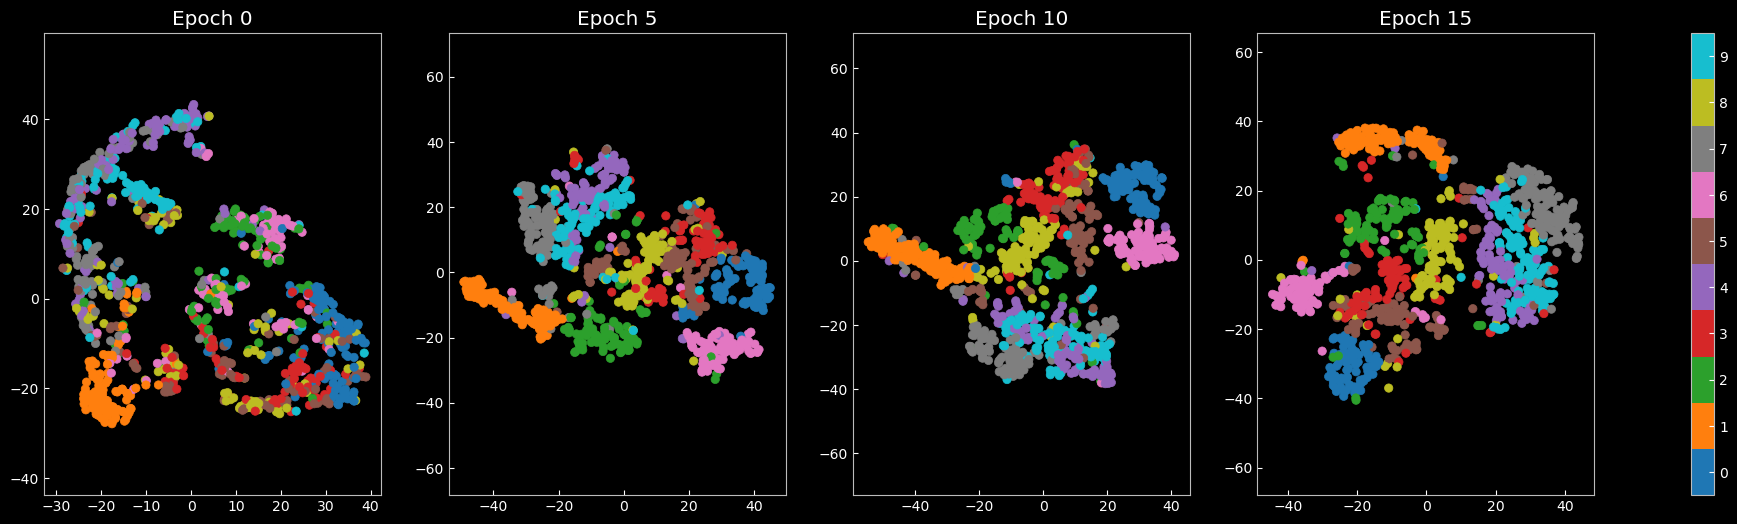

In [14]:
f, a = plt.subplots(ncols=4)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)